In [1]:
%reload_ext autoreload
%autoreload 1
import torch 
import sys
sys.path.append('..')
from torch import nn 
from torch.nn import functional as F
from torch import optim
from utils.loader import load,PairSetMNIST,Training_set,Test_set, Training_set_split,Validation_set
from torch.utils.data import Dataset, DataLoader
from models.Le_Net import  LeNet_sharing, train_Le_Net_Weight_Sharing
from models.Inception_Net import Inception_block, conv_block, Google_Net, Auxiliary_loss, train_inception
from utils.evaluate_ws import compute_metrics, validate_model, evaluate_model, grid_search
from matplotlib import pyplot as plt
import torch.cuda as cuda 
from utils.plot import boxplot

In [3]:
# parameters to optimize
drop_prob = [0.1,0.2, 0.3, 0.4]
hidden_layers = [50, 100, 150, 200]

# number of seeds to perform
seeds = [19, 123, 1234, 6453] 
#,234, 2345, 234567, 12345654]


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

for seed in seeds:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # if using GPU

    print ("seed : " + str(seed))

    train_results, test_losses, test_accuracies = grid_search(LeNet_sharing,train_Le_Net_Weight_Sharing, drop_prob, hidden_layers,                 mini_batch_size=100, optimizer =optim.Adam,criterion = nn.CrossEntropyLoss(), n_epochs=40, eta=1e-3, lambda_l2 = 0,rotate = False,             translate=False,swap_channel = False,GPU=True)

    # compute indices of best parameter optimization here 
    validation_grid = torch.mean(train_results[:,:,:,3,39], dim= 2) # compute mean validation accuracy at last Epoch on 3 loops
    idx = torch.where(validation_grid == validation_grid.max())

    if len(idx[0]) >=2:
        idx=idx[0]

    opt_prob = drop_prob[idx[0].item()]
    opt_hidden_layer = hidden_layers[idx[1].item()]
    print(opt_prob, opt_hidden_layer)

end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))



seed : 19
prob : 0.1, nb_hidden : 50 (n= 0)
prob : 0.1, nb_hidden : 50 (n= 1)
prob : 0.1, nb_hidden : 50 (n= 2)


KeyboardInterrupt: 

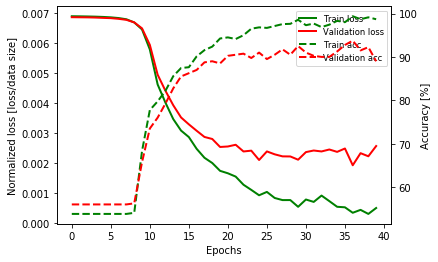

Seed 0 | Test Loss: 0.0045 | Test Accuracy: 84.70%



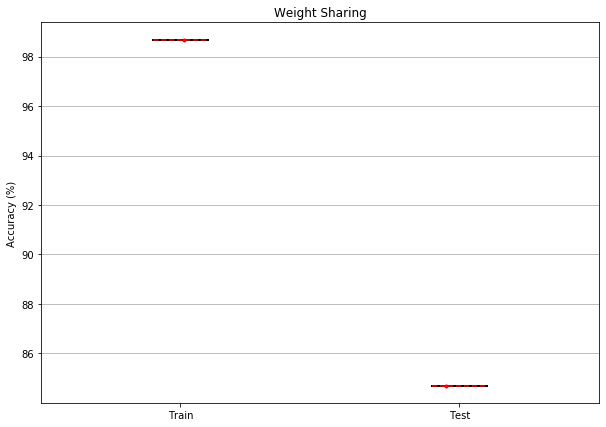

In [2]:
# evaluate model on 10 trials for final results 

seeds = [3, 4, 452, 2345, 1234, 2134, 12345, 12377, 56765, 567776, 234, 1234, 1324543, 1234 , 345, 213456, 21345] # random seeds

train_results, test_losses, test_accuracies = evaluate_model(LeNet_sharing,train_Le_Net_Weight_Sharing, seeds, swap_channel=True, GPU=True)

data = torch.stack([train_results[:,1,39], test_accuracies])  # group data for boxplot
boxplot(data)